this makes plots which contain the distance from the center of the tumor on the x-axis

In [1]:
import random
%pylab inline
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid.inset_locator import inset_axes
sns.set_style('white')
sns.set_context('paper', font_scale=1.5)
from glob import glob
YELLOW = sns.xkcd_rgb["amber"]
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
CTC_SIZES = [(2,7), (8,12), (13,17), (18,22),(23,30)]

ALTERNATE_COLORS = sns.xkcd_palette(["vomit green", "orangish brown", "azure", "dark pink"])
small_c, med_c, big_c, biggest_c = ALTERNATE_COLORS

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [43]:
# load data from HCC tumor

HCC = pd.read_csv('./empirical/HCtumordata.csv')
HCC = HCC.sort(columns='r')

/Users/Zaf/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [2]:
import random
import json
import statsmodels.api as sm

In [3]:
# creates a color map that you can use like this: create_colormap(y) --> rgba color value
def create_colormap(colormap_name='cubehelix_r', with_yellow=False,n_colors=8, use_range=(1,3,4,6,7,7), start_bin=2, each_bin=5, return_colormap=False):
    colors = sns.color_palette(colormap_name, n_colors=n_colors)
    bin_ = start_bin
    color_mapping = {}
    for color in use_range: #map through all colors
        for i in xrange(each_bin):
            color_mapping[bin_+i] = colors[color]
        bin_= bin_ + each_bin
    
    if return_colormap:
        col_list = [ colors[i] for i in use_range]
        if with_yellow:
            col_list = [ YELLOW ] + col_list
#             col_list = [ YELLOW ] + col_list + ALTERNATE_COLORS
        return mpl.colors.ListedColormap( col_list )
    def c_mapper(i):
        print i
        try:
            if i == 1 and with_yellow:
                return YELLOW
            elif i == 100:
                return small_c
            elif i == 1000:
                return med_c
            elif i == 10000:
                return big_c
            elif i == 20000:
                return biggest_c
            else:
                return color_mapping[i]
        except Exception as e:
            print('error')
            return color_mapping[sorted(color_mapping.keys())[-1]]
    return c_mapper

In [4]:
def exponential_mean_function(x_i, y_i,k=1):
    """
        @params:
            x_i : all x_i points available
            y_i : the y_i values to average over
        @returns
            a function that can be evaluated for the mean at any point x
        
    """
    def exponential_mean_at(x):
        """
            @params:
                x: a np.array or float where the average value needs to be returned
            @returns
                <y(x)> : average value at position x
        """
        w = exp(-k*(x-x_i)**2)
        return np.dot(w, y_i) / np.sum(w)
    
    return exponential_mean_at


In [5]:
def prepare_data2(folder, yaxis='S_list_ordered', k=0.01, pts=100):
    """
        Load data from .npy files
    """
    
    
    assert yaxis in ['S_list01_big', 'S_list001_big', 'S_list00_big', 'S_list_simulated','S_list_ordered', 'D_list_ordered', 'cdrv_list_ordered', 'csnp_list_ordered'], 'yaxis is not recognized for prepare_data2'
    
    ISBIG = yaxis in ['S_list01_big', 'S_list001_big', 'S_list00_big']
    dist_file = 'dist_'+yaxis.split('_list')[1] if ISBIG else 'deltas_ordered'
    if len(glob(folder+'Dec2*/'+dist_file+'.npy')) == 0:
        raise Exception('No files found in '+folder)

    distances = np.load(glob(folder+'Dec*/'+dist_file+'.npy')[0])

    if not ISBIG:
        distances = distances[:, 0]
        
    S = np.load(glob(folder+'Dec*/'+yaxis+'.npy')[0])
    prepped = {}
    all_sizes = [1,2,3,4] if yaxis in ['S_list01_big', 'S_list001_big', 'S_list00_big'] else list([1] + CTC_SIZES)
    for ctc_size in all_sizes:
        slice_range = None
        x = None
        y = None
        color = None
        if type(ctc_size) is int: # check if this is an int so that we can handle different compared to a range...
            x = distances
            y = S[:, ctc_size-1]
            if ISBIG:
                y = y[:100]
                x = distances[:100, ctc_size-1]
            ctc_size = (ctc_size,)
        else:
            slice_range = range(ctc_size[0]-1, ctc_size[1])
            x = np.repeat(distances, ctc_size[1]-ctc_size[0]+1)
            y = S[:,slice_range].reshape(1,-1)[0]
        
        minp = 0
        maxp = distances.max() #define the maximum tumor size
        x_av = np.linspace(minp, maxp, pts)
        moving_avg_function = np.vectorize(exponential_mean_function(x,y, k = k)) # returns a function
        y_av = moving_avg_function(x_av)
        
        if ISBIG:
#             print 'idx=',ctc_size[0]
            _ctc_size = 10**(ctc_size[0]+1) if ctc_size[0] != 4 else 2*10**4
#             print 'powered=',_ctc_size
            ctc_size = (_ctc_size, ) 
        prepped[ctc_size] = [x_av, y_av]
        
    return prepped

In [6]:
def cross_sim_average(samples):
    to_be_returned = {}
    ctc_sizes = samples[0].keys()
    for ctc_size in ctc_sizes:
        to_be_avged_x = []
        to_be_avged_y = []
        # go through all samples and extract that 
        for sample in samples:
            to_be_avged_x.append(sample[ctc_size][0])
            to_be_avged_y.append(sample[ctc_size][1])

        to_be_avged_x = np.array(to_be_avged_x)
        to_be_avged_y = np.array(to_be_avged_y)
        
        x_avgd = np.mean(to_be_avged_x, axis=0)
        y_avgd = np.mean(to_be_avged_y, axis=0)
        to_be_returned[ctc_size] = [x_avgd, y_avgd]
        
    return to_be_returned
        
        

In [7]:
def data_to_plot(folder, seeds, yaxis='unique_combos', k=0.01, pts=100, mode=1, d='005'):
    samples = [] # all samples will be held here
    # first prep the data for each seed
#     print 'DATA_TO_PLOT - FOLDER:'+folder+' SEEDS:'+str(seeds)+' d:'+d

    for seed in seeds:
        this_folder = folder+'_'+d+'_outs_'+seed+'/'
#         print this_folder
        try:
            if mode == 1:
                samples.append(prepare_data1(this_folder, yaxis=yaxis, k=k, pts=pts))
            else:
                samples.append(prepare_data2(this_folder, yaxis=yaxis, k=k, pts=pts))
        except Exception as e:
            print 'data_to_plot Exception:'+str(e)
            print 'Skipped Folder:'+this_folder
#             raise e
    # produce the cross sample average
    cross_sample_averaged = cross_sim_average(samples)
    return cross_sample_averaged


In [8]:
def plot_it(cross_sample_averaged, ax):
    colors = create_colormap(with_yellow=True)
    for ctc_size in cross_sample_averaged.keys():
        x,y = cross_sample_averaged[ctc_size]
        ax.plot(x,y, color=colors(ctc_size[0]))
        
        if ctc_size[0] == 1:
            print 'mean(s(1))',np.mean(y)
            print 'std(s(1))', np.std(y)
            print 's(1)_core',np.mean(y[:10])
            print 's(1)_edge',np.mean(y[10:])

In [9]:
def plot_density(ax, folder, seeds, d='005'):
    r_samples = [] # all samples will be held here
    rho_samples = [] # all samples will be held here
    # first prep the data for each seed
#     print 'PLOT DENSITY folder:'+folder+' seeds:'+str(seeds)+' d='+d
    for seed in seeds:
        this_folder = folder+'_'+d+'_outs_'+seed+'/'
#         print this_folder
        try:
            r_samples.append(np.load(glob(this_folder+'/Dec*/r_meaned.npy')[0]))
            rho_samples.append(np.load(glob(this_folder+'/Dec*/rho2.npy')[0]))
        except Exception as e:
            print 'Exception: '+str(e)
            print 'Skipped Folder: '+this_folder
    print len(r_samples)
    print len(rho_samples)
    r = np.mean(np.array(r_samples), axis=0)
    rho = np.mean(np.array(rho_samples), axis=0)

    ax1_r = ax.twinx()
    ax1_r.fill_between(r, rho,alpha=0.09,color=(0,0,0))
    ax1_r.set_ylim([0,1.1])
    ax1_r.set_ylabel('Tumor Cell Density', rotation=-90,labelpad=15)


In [10]:
def create_colorbar(subaxes, with_yellow=False):
    cb = mpl.colorbar.ColorbarBase(subaxes, cmap=create_colormap(return_colormap=True, with_yellow=with_yellow),
    #                                 tick=['2-7', '8-13', '14-19', '20-25', '26-30'],
    #                                 extend='both',
                                    # Make the length of each extension
                                    # the same as the length of the
                                    # interior colors:
    #                                 extendfrac='auto',
    #                                 ticks=bounds,
                                    spacing='uniform',
                                    orientation='horizontal')
    cb.set_label('Cluster Sizes')
    cb.ax.get_xaxis().labelpad = 0

    ticklocs = [0.03, 0.2, 0.33, 0.5, 0.65,0.85] # location of ticks
    ticklabels = ['1', '2-7', '8-12', '13-17', '18-22', '23-30', '10^2', '10^3', '10^4', '2*10^4'] # tick labels

#     ticklocs = [0.03, 0.1, 0.21, 0.33, 0.4, 0.5, 0.65, 0.75, 0.85, 0.9] # location of ticks
#     ticklabels = ['1', '2-7', '8-12', '13-17', '18-22', '23-30', '10^2', '10^3', '10^4', '2*10^4'] # tick labels

    if not with_yellow:
        ticklabels = ticklabels[1:]
        ticklocs = list(np.linspace(0.05,0.6,4))+[0.8]

    cb.set_ticks(ticklocs)
    cb.ax.set_xticklabels(ticklabels, fontsize = 9, rotation=30)




In [13]:
def S_plot(root_folder, seeds, k=0.01, pts=100, d='005'):

    fig = plt.figure(figsize=(11,3))

    ax = fig.add_subplot(131)
    folder = root_folder+'/1_0'
    d2='0'

    plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d2), ax)
    plot_density(ax, folder, seeds, d=d2)
    
    ax.set_title('(a) No Turnover')
    ax.set_xlim([50,325])
#     ax.set_ylim([0,])
    ax.set_ylabel('Mean # Somatic Mutations')
    ax.set_xlabel('Distance from Centre of Tumor (cells)')

    cmap_ax = ax # for later use
    
    ax = fig.add_subplot(132)
    folder = root_folder+'/1_1'
    
    plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d), ax)
    plot_density(ax, folder, seeds, d=d)
    
    ax.set_title('(b) Surface Turnover')
    ax.set_xlim([50,325])
    ax.set_ylabel('Mean # Somatic Mutations')
    ax.set_xlabel('Distance from Centre of Tumor (cells)')
#     ax.set_ylim([0,1])

    ax = fig.add_subplot(133)
    folder = root_folder+'/1_0'
    
    plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d), ax)
    plot_density(ax, folder, seeds, d=d)
    
    ax.set_title('(c) Turnover')
    ax.set_ylabel('Mean # Somatic Mutations')
    x_max = 350 if d=='02' else 325 
    x_max = 750 if d=='065' else x_max 
    ax.set_xlim([50,x_max])
    ax.set_xlabel('Distance from Centre of Tumor (cells)')
#     ax.set_ylim([0,50])

    fig.tight_layout(pad=1, w_pad=0.5)
    
    
    subaxes = inset_axes(cmap_ax,
                        width="90%", # width = 30% of parent_bbox
                        height=0.15, # height : 1 inch
                        loc=2)
    
    create_colorbar(subaxes,with_yellow=True)
    fig.suptitle('d=0.'+d[1:],x =0.5, y=1)
    return fig


# Figure 3

In [45]:
def alternating_power_plot(power_plots, ax):

    cmapa = create_colormap()
    HUGE_KEYS_ = ['powhuge100', 'powhuge1000', 'powhuge10000']
    KEYS_ = ['pow2001', 'pow7001', 'pow12001', 'pow17001', 'pow22001', 'powbig001'] + HUGE_KEYS_
    COLORS_ = [YELLOW, cmapa(4), cmapa(9), cmapa(14), cmapa(20), cmapa(24), small_c, big_c, biggest_c]
    LABELS_ = ['size=1', 'size=(2,7)', 'size=(8,12)', 'size=(13,17)', 'size=(18,22)', 'size=(23,30)', 'size=100', 'size=1000', 'size=10000']
    
    for k, color, label in zip(KEYS_,COLORS_,LABELS_):
        x_ = power_plots['x_h'] if k in HUGE_KEYS_ else power_plots['x']
        
        
        pos = np.array(power_plots[k]['pos'])
        neg = np.array(power_plots[k]['neg'])
        pos_tot = np.sum(pos)
        neg_tot = np.sum(neg)
        
        if np.any(power_plots[k]['pos']) and pos_tot > neg_tot:
            ax.scatter(x_, power_plots[k]['pos'], color = color, marker='o', label=label)
        if np.any(power_plots[k]['neg']) and neg_tot > pos_tot:
            ax.scatter(x_, -np.array(power_plots[k]['neg']), color = color, marker='^', label=label)


    ax.legend(loc=1,labelspacing=0,handlelength=0,frameon=True)
    ax.plot(np.ones(30)*23, np.linspace(-1.5,1.5,30), '--',color='gray')
    ax.set_xlim([0,80])
    ax.set_ylim([-1.1,1.1])
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Signed Proportion of \nSignificant Regressions')
    
    return ax

In [35]:
def empirical_compare_plot(root_folder, seeds):
    NT_folder = root_folder+'/1_0'
    ST_folder = root_folder+'/1_1'
    T_folder = root_folder+'/1_0'

    HCC = pd.read_csv('./empirical/HCtumordata.csv')
    HCC = HCC.sort(columns='r')
    
    
    f = plt.figure(figsize=(10,8))

    

    ax = f.add_subplot(221)
    ax.set_xlabel('Distance from Centre of Tumor (cm)')
    ax1_r = ax.twinx()
    ax1_r.fill_between(HCC.r, HCC.purity, alpha=0.09,color=(0,0,0))
    ax1_r.set_ylabel('Tumor Purity', rotation=-90,labelpad=15)
    x = np.linspace(HCC.r.min(), HCC.r.max(), 43)
#     y = exp_avg(x)
    dist_sampled_ = sm.add_constant(HCC.r)
    model = sm.OLS(HCC.SNV_corrected,dist_sampled_)
    results = model.fit()
    
    y = results.predict(sm.add_constant(x))
    ax.plot(x, y, label='Regression (p='+str(round(results.pvalues[1], 3))+')', color=biggest_c)
    ax.scatter(HCC.r, HCC.SNV_corrected, label='Raw Counts', color=biggest_c)
    ax.set_xlim([0,HCC.r.max()+0.1])
    ax.set_ylim(bottom=0)
    ax.set_ylabel('# Somatic Mutations')
    ax.legend(loc=3)
    ax.set_title('(a) Somatic Mutations in HCC Patient\n')  

    
    folder = root_folder+'/1_0'
    ax = f.add_subplot(223)
    plot_density(ax, folder, seeds, d='0')
    
    S = np.load('/Volumes/Stockage/u0.03simulations/1_0_0_outs_101/Dec2_pipe_out_Sun_Dec_18_09_36_53_2016/S_list01_big.npy')[:,3]
    distances = np.load('/Volumes/Stockage/u0.03simulations/1_0_0_outs_101/Dec2_pipe_out_Sun_Dec_18_09_36_53_2016/dist_01_big.npy')[:,3]
    sampled = random.sample(xrange(0,100), 23)
    s_sampled = S[sampled]
    dist_sampled = distances[sampled]
    ax.scatter(dist_sampled, s_sampled, label='Raw Counts', color=biggest_c)
#     exp_avg = np.vectorize(exponential_mean_function(dist_sampled, s_sampled ,k=0.001))
    x = np.linspace(distances.min(), distances.max(), 43)
#     y = exp_avg(x)
    dist_sampled_ = sm.add_constant(dist_sampled)
    model = sm.OLS(s_sampled,dist_sampled_)
    results = model.fit()
    
    y = results.predict(sm.add_constant(x))
    ax.plot(x, y, label='Regression (p='+str(round(results.pvalues[1], 3))+')', color=biggest_c)
    ax.set_ylabel('# Somatic Mutations')
    ax.set_xlabel('Distance from Centre of Tumor (cells)')
    ax.set_title('(c) No Turnover (>10% frequency)\n')  
    ax.set_xlim([0, 325])
    ax.legend(loc=2)
#     ax.set_ylim([0,60])
    
    ax = f.add_subplot(224)
    
    plot_density(ax, folder, seeds, d='02')
    S = np.load('/Volumes/Stockage/u0.03simulations/1_0_02_outs_101/Dec2_pipe_out_Sun_Dec_18_21_02_27_2016/S_list01_big.npy')[:,3]
    distances = np.load('/Volumes/Stockage/u0.03simulations/1_0_02_outs_101/Dec2_pipe_out_Sun_Dec_18_21_02_27_2016/dist_01_big.npy')[:,3]
    sampled = random.sample(xrange(0,100), 23)
    s_sampled = S[sampled]
    dist_sampled = distances[sampled]
    ax.scatter(dist_sampled, s_sampled, label='Raw Counts', color=biggest_c)
#     exp_avg = np.vectorize(exponential_mean_function(dist_sampled, s_sampled ,k=0.001))
    x = np.linspace(distances.min(), distances.max(), 43)
#     y = exp_avg(x)
    dist_sampled_ = sm.add_constant(dist_sampled)
    model = sm.OLS(s_sampled,dist_sampled_)
    results = model.fit()
    
    y = results.predict(sm.add_constant(x))
    ax.plot(x, y, label='Regression (p='+str(round(results.pvalues[1], 3))+')', color=biggest_c)
    ax.set_xlabel('Distance from Centre of Tumor (cells)')
    
    ax.legend(loc=2)

    ax.set_xlim([0, 350])
    ax.set_ylabel('# Somatic Mutations')
    ax.set_title('(d) Turnover (>10% frequency)\n')  
    
    cmapa = create_colormap()
    
    ax = f.add_subplot(222)
    alternating_power_plot(json.load(open('./turnover_power.json', 'r')), ax)
    ax.set_title('(b) Power Analysis \n (p<0.01)')
    
    
    f.tight_layout(h_pad=1.0,w_pad=0.7)
    return f

/Users/Zaf/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


1
1
1
1
4
9
14
20
24


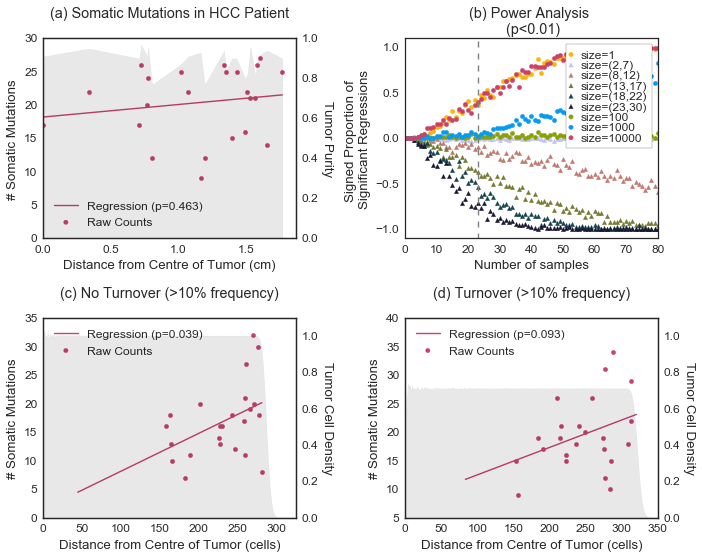

In [46]:
empirical_compare_plot('/Volumes/Stockage/u0.03simulations',seeds=['101']).savefig('fig03.pdf')

In [103]:
def power_plot(power_plots):
    f = plt.figure()
    ax = f.add_subplot(111)
    cmapa = create_colormap()
    
    ax.scatter(power_plots['x'], power_plots['pow2001'], color = YELLOW, marker='o', label='size=1')
    ax.scatter(power_plots['x'], power_plots['pow7001'], color=cmapa(4), marker='o', label='size=(2,7)')
    ax.scatter(power_plots['x'], power_plots['pow12001'], color=cmapa(9), marker='o', label='size=(8,12)')
    ax.scatter(power_plots['x'], power_plots['pow17001'], color=cmapa(14), marker='o', label='size=(13,17)')
    ax.scatter(power_plots['x'], power_plots['pow22001'], color=cmapa(20), marker='o', label='size=(18,22)')
    ax.scatter(power_plots['x'], power_plots['powbig001'], color=cmapa(24), marker='o', label='size=(23,30)')
    
    ax.scatter(power_plots['x_h'], power_plots['powhuge001'], color=biggest_c, marker='o', label='size=10000')
    ax.legend(loc=4)
    ax.plot(np.ones(30)*23, np.linspace(0,1.5,30), '--',color='gray')
    ax.set_xlim([0,500])
    ax.set_ylim([0,1.1])
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Proportion of \nSignificant Regressions')
    ax.set_title('(a) Power Analysis \n Significance threshold = 0.01')
    
    return f

# supplementary figure 7

4
9
14
20
24


(0, 1.01)

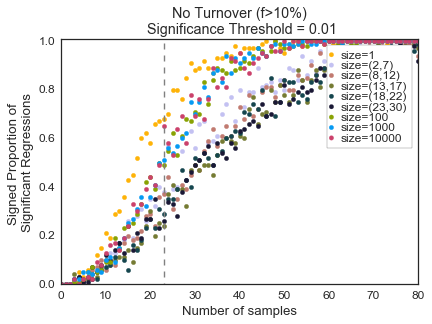

In [59]:
alt_powers = json.load(open('./noturnover_power.json', 'r'))
f = plt.figure()
ax = f.add_subplot(111)
alternating_power_plot(alt_powers, ax)
ax.set_title('No Turnover (f>10%)\n Significance Threshold = 0.01')
ax.set_ylim([0,1.01])

# figure 2

In [37]:
def S_plot_paper(root_folder, seeds, k=0.01, pts=100, cutoff='00'):

    fig = plt.figure(figsize=(13,3))

    ax = fig.add_subplot(141)
    folder = root_folder+'/1_0'
    d2='0'

    plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d2), ax)
#     plot_it(data_to_plot(folder, seeds, yaxis='S_list'+cutoff+'_big', mode=2, d=d2), ax)
    plot_density(ax, folder, seeds, d=d2)


    
    ax.set_title('(a) No Turnover')
    ax.set_xlim([50,325])
    ax.set_ylim([0,30])
    ax.set_ylabel('Mean # Somatic Mutations')
    ax.set_xlabel('Distance from Centre \n of Tumor (cells)')

    cmap_ax = ax # for later use
    
    d = '005'
    ax = fig.add_subplot(142)
    folder = root_folder+'/1_0'
    
    plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d), ax)
#     plot_it(data_to_plot(folder, seeds, yaxis='S_list'+cutoff+'_big', mode=2, d=d), ax)
    plot_density(ax, folder, seeds, d=d)
    
    ax.set_title('(b) Turnover, d=0.'+d[1:])
    ax.set_xlim([50,325])
    ax.set_ylabel('Mean # Somatic Mutations')
    ax.set_xlabel('Distance from Centre \n of Tumor (cells)')
#     ax.set_ylim([0,1])


    d = '01'
    ax = fig.add_subplot(143)
    folder = root_folder+'/1_0'
    plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d), ax)
#     plot_it(data_to_plot(folder, seeds, yaxis='S_list'+cutoff+'_big', mode=2, d=d), ax)
    plot_density(ax, folder, seeds, d=d)
    
    ax.set_title('(c) Turnover, d=0.'+d[1:])
    ax.set_ylabel('Mean # Somatic Mutations')
    x_max = 350 if d=='02' else 325 
    x_max = 750 if d=='065' else x_max 
    ax.set_xlim([50,x_max])
    ax.set_xlabel('Distance from Centre \n of Tumor (cells)')
    
    
    d = '02'
    ax = fig.add_subplot(144)
    folder = root_folder+'/1_0'
    
    plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d), ax)
#     plot_it(data_to_plot(folder, seeds, yaxis='S_list'+cutoff+'_big', mode=2, d=d), ax)
    plot_density(ax, folder, seeds, d=d)
    
    ax.set_title('(d) Turnover, d=0.'+d[1:])
    ax.set_ylabel('Mean # Somatic Mutations')
    x_max = 350 if d=='02' else 325 
    x_max = 750 if d=='065' else x_max 
    ax.set_xlim([50,x_max])
    ax.set_xlabel('Distance from Centre \n of Tumor (cells)')
#     ax.set_ylim([0,50])

    fig.tight_layout(pad=1, w_pad=0.5)
    
    
    subaxes = inset_axes(cmap_ax,
                        width="90%", # width = 30% of parent_bbox
                        height=0.15, # height : 1 inch
                        loc=2)
    
    create_colorbar(subaxes,with_yellow=True)
    return fig



2
23
18
1
mean(s(1)) 5.97498691633
std(s(1)) 3.0051948453
s(1)_core 1.83038382509
s(1)_edge 6.43549837091
8
13
10
10
2
23
18
1
mean(s(1)) 6.43942833396
std(s(1)) 2.95565829879
s(1)_core 2.27973513008
s(1)_edge 6.90161646772
8
13
10
10
2
23
18
1
mean(s(1)) 6.83907951405
std(s(1)) 2.92470641148
s(1)_core 2.43708351569
s(1)_edge 7.32819018054
8
13
10
10
2
23
18
1
mean(s(1)) 8.32013690364
std(s(1)) 2.68371136973
s(1)_core 3.99999911516
s(1)_edge 8.80015221347
8
13
10
10


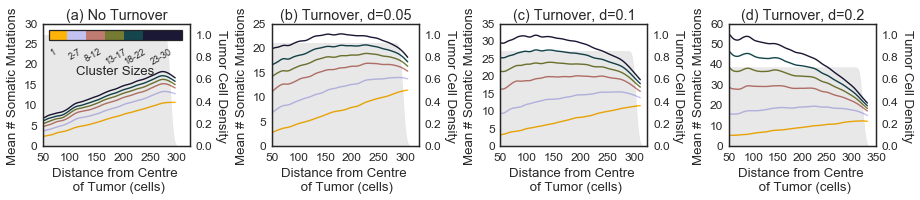

In [48]:
S_plot_paper('/Volumes/Stockage/u0.03simulations/',['101','1','2','0','3','4','5','102','12151', '12152'], cutoff='00').savefig('fig02.pdf')

# supplementary figure 2

In [49]:
def S_plot_paper_supp(root_folder, seeds, k=0.01, pts=100, cutoff='00'):

    fig = plt.figure(figsize=(13,3))

#     ax = fig.add_subplot(141)
#     folder = root_folder+'/1_0'
#     d2='065'

#     plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d2), ax)
# #     plot_it(data_to_plot(folder, seeds, yaxis='S_list'+cutoff+'_big', mode=2, d=d2), ax)
#     plot_density(ax, folder, seeds, d=d2)


    
#     ax.set_title('(a) No Turnover')
#     ax.set_xlim([50,325])
#     ax.set_ylim([0,30])
#     ax.set_ylabel('Mean # Somatic Mutations')
#     ax.set_xlabel('Distance from Centre of Tumor')

    
    d = '005'
    ax = fig.add_subplot(141)
    
    cmap_ax = ax # for later use

        
        
    folder = root_folder+'/1_1'
    
    plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d), ax)
#     plot_it(data_to_plot(folder, seeds, yaxis='S_list'+cutoff+'_big', mode=2, d=d), ax)
    plot_density(ax, folder, seeds, d=d)
    
    ax.set_title('(b) Surface Turnover, d=0.'+d[1:])
    ax.set_xlim([50,325])
    ax.set_ylabel('Mean # Somatic Mutations')
    ax.set_xlabel('Distance from Centre \n of Tumor (cells)')
#     ax.set_ylim([0,1])


    d = '01'
    ax = fig.add_subplot(142)
    folder = root_folder+'/1_1'
    plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d), ax)
#     plot_it(data_to_plot(folder, seeds, yaxis='S_list'+cutoff+'_big', mode=2, d=d), ax)
    plot_density(ax, folder, seeds, d=d)
    
    ax.set_title('(c) Surface Turnover, d=0.'+d[1:])
    ax.set_ylabel('Mean # Somatic Mutations')
    x_max = 350 if d=='02' else 325 
    x_max = 750 if d=='065' else x_max 
    ax.set_xlim([50,x_max])
    ax.set_xlabel('Distance from Centre \n of Tumor (cells)')
    
    
    d = '02'
    ax = fig.add_subplot(143)
    folder = root_folder+'/1_1'
    
    plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d), ax)
#     plot_it(data_to_plot(folder, seeds, yaxis='S_list'+cutoff+'_big', mode=2, d=d), ax)
    plot_density(ax, folder, seeds, d=d)
    
    ax.set_title('(d) Surface Turnover, d=0.'+d[1:])
    ax.set_ylabel('Mean # Somatic Mutations')
    x_max = 350 if d=='02' else 325 
    x_max = 750 if d=='065' else x_max 
    ax.set_xlim([50,x_max])
    ax.set_xlabel('Distance from Centre \n of Tumor (cells)')
#     ax.set_ylim([0,50])

    
    d = '065'
    ax = fig.add_subplot(144)
    folder = root_folder+'/1_1'
    
    plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d), ax)
#     plot_it(data_to_plot(folder, seeds, yaxis='S_list'+cutoff+'_big', mode=2, d=d), ax)
    plot_density(ax, folder, seeds, d=d)
    
    ax.set_title('(e) Surface Turnover, d=0.'+d[1:])
    ax.set_ylabel('Mean # Somatic Mutations')
    x_max = 350 if d=='02' else 325 
#     x_max = 750 if d=='065' else x_max 
    ax.set_xlim([50,x_max])
    ax.set_xlabel('Distance from Centre \n of Tumor (cells)')
#     ax.set_ylim([0,50])

    fig.tight_layout(pad=1, w_pad=0.5)
    
    
    subaxes = inset_axes(cmap_ax,
                        width="90%", # width = 30% of parent_bbox
                        height=0.15, # height : 1 inch
                        loc=2)
    
    create_colorbar(subaxes,with_yellow=True)
    return fig



2
23
18
1
mean(s(1)) 5.87838490517
std(s(1)) 2.95725010869
s(1)_core 1.72830109801
s(1)_edge 6.33950532819
8
13
10
10
2
23
18
1
mean(s(1)) 5.90679016804
std(s(1)) 3.12743796359
s(1)_core 1.69493960368
s(1)_edge 6.37477356409
8
13
10
10
2
23
18
1
mean(s(1)) 5.81108447036
std(s(1)) 3.09440768341
s(1)_core 1.36344050309
s(1)_edge 6.30526713339
8
13
10
10
2
23
18
1
mean(s(1)) 11.8222292772
std(s(1)) 5.60512897193
s(1)_core 3.4201490467
s(1)_edge 12.7557937472
8
13
10
10


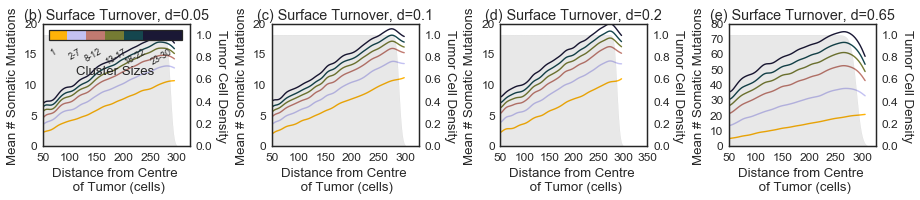

In [51]:
S_plot_paper_supp('/Volumes/Stockage/u0.03simulations/',['101','1','2','0','3','4','5','102','12151', '12152'], cutoff='00').savefig('Splot_supplementary.pdf')

In [43]:
def S_all_death(root_folder, seeds, k=0.01, pts=100, cutoff='00'):

    fig = plt.figure(figsize=(13,3))

    d = '005'
    ax = fig.add_subplot(141)
    folder = root_folder+'/1_0'
    
    plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d), ax)
#     plot_it(data_to_plot(folder, seeds, yaxis='S_list'+cutoff+'_big', mode=2, d=d), ax)
    plot_density(ax, folder, seeds, d=d)
    
    ax.set_title('(a) Turnover, d=0.'+d[1:])
    ax.set_xlim([50,325])
    ax.set_ylabel('Mean # Somatic Mutations')
    ax.set_xlabel('Distance from Centre of Tumor')
#     ax.set_ylim([0,1])


    d = '01'
    ax = fig.add_subplot(142)
    folder = root_folder+'/1_0'
    plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d), ax)
#     plot_it(data_to_plot(folder, seeds, yaxis='S_list'+cutoff+'_big', mode=2, d=d), ax)
    plot_density(ax, folder, seeds, d=d)
    
    ax.set_title('(v) Turnover, d=0.'+d[1:])
    ax.set_ylabel('Mean # Somatic Mutations')
    x_max = 350 if d=='02' else 325 
    x_max = 750 if d=='065' else x_max 
    ax.set_xlim([50,x_max])
    ax.set_xlabel('Distance from Centre of Tumor')
    
    
    d = '02'
    ax = fig.add_subplot(143)
    folder = root_folder+'/1_0'
    
    plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d), ax)
#     plot_it(data_to_plot(folder, seeds, yaxis='S_list'+cutoff+'_big', mode=2, d=d), ax)
    plot_density(ax, folder, seeds, d=d)
    
    ax.set_title('(c) Turnover, d=0.'+d[1:])
    ax.set_ylabel('Mean # Somatic Mutations')
    x_max = 350 if d=='02' else 325 
    x_max = 750 if d=='065' else x_max 
    ax.set_xlim([50,x_max])
    ax.set_xlabel('Distance from Centre of Tumor')
#     ax.set_ylim([0,50])

    fig.tight_layout(pad=1, w_pad=0.5)
    
    ax = fig.add_subplot(144)
    folder = root_folder+'/1_0'
    d2='065'

    plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d2), ax)
#     plot_it(data_to_plot(folder, seeds, yaxis='S_list'+cutoff+'_big', mode=2, d=d2), ax)
    plot_density(ax, folder, seeds, d=d2)


    
    ax.set_title('(d) Turnover, d=0.65')
    ax.set_xlim([50,775])
#     ax.set_ylim([0,30])
    ax.set_ylabel('Mean # Somatic Mutations')
    ax.set_xlabel('Distance from Centre of Tumor')

    cmap_ax = ax # for later use
    
    
    subaxes = inset_axes(cmap_ax,
                        width="90%", # width = 30% of parent_bbox
                        height=0.15, # height : 1 inch
                        loc=2)
    
    create_colorbar(subaxes,with_yellow=True)
    return fig



# supplementary figure 3

data_to_plot Exception:No files found in ../u0.03simulations/1_0_065_outs_2/
Skipped Folder:../u0.03simulations/1_0_065_outs_2/
data_to_plot Exception:No files found in ../u0.03simulations/1_0_065_outs_101/
Skipped Folder:../u0.03simulations/1_0_065_outs_101/
2
23
18
1
mean(s(1)) 66.6949381956
std(s(1)) 1.77921854961
s(1)_core 69.2984257294
s(1)_edge 66.4056618029
8
13
Exception: list index out of range
Skipped Folder: ../u0.03simulations/1_0_065_outs_2/
Exception: list index out of range
Skipped Folder: ../u0.03simulations/1_0_065_outs_101/
7
7


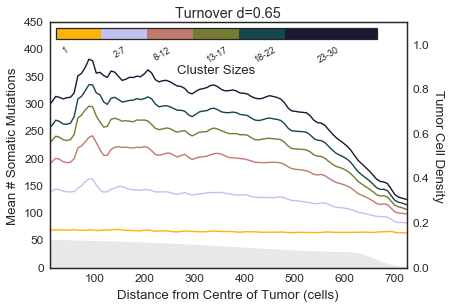

In [42]:
f = plt.figure()
ax = f.add_subplot(111)
plot_it(data_to_plot('../u0.03simulations/1_0', ['0','1','2','3','5','101', '102', '12151', '12152'] , yaxis='S_list_ordered', mode=2, d='065'), ax)
plot_density(ax, '../u0.03simulations/1_0', ['0','1','2','3','5','101', '102', '12151', '12152'] , d='065')
subaxes = inset_axes(ax,
                    width="90%", # width = 30% of parent_bbox
                    height=0.15, # height : 1 inch
                    loc=2)

create_colorbar(subaxes,with_yellow=True)
ax.set_ylim([0.01, 450])
ax.set_xlim([10, 725])
ax.set_xlabel('Distance from Centre of Tumor (cells)')
ax.set_ylabel('Mean # Somatic Mutations')
ax.set_title('Turnover d=0.65')
f.savefig('t065_supp.pdf')